In [ ]:
# !pip install python-Levenshtein -q

In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import re
import matplotlib.pyplot as plt
import nltk
import nomquamgender as nqg
from wordcloud import WordCloud
from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)

In [2]:
csv_file_path = "./project_3.csv"
output_csv_path = "output.csv"
df = pd.read_csv(csv_file_path)
output_df = df.copy()

# Simple Data Exploration over the whole dataset

In [3]:
df_columns = [column for column in df.columns]
print(df_columns)

['prefix', 'lastname', 'firstname', 'firstname_mother', 'firstname_father', 'description', 'inquiry', 'dob', 'account_creation_date', 'last_transaction_date', 'account_resiliation_date', 'first_contact_date', 'last_contact_date', 'latlon_home', 'latlon_work', 'x35_bank_branch', 'email_work', 'email_personnal', 'email_sso', 'email_vpn', 'xml_authent_token', 'profile_json', 'cia_info_json', 'salary', 'first_salary', 'taxable_income', 'transaction_amount', 'credit_card_score', 'credit_card_number', 'weight', 'height', 'shoe_size', 'bank_balance', 'address', 'city', 'zip', 'country', 'customer_code', 'customer_uid', 'android_platform', 'user_agent', 'blog_url', 'customer_segment_code', 'customer_market_code', 'customer_fico_score']


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prefix                    10000 non-null  object 
 1   lastname                  10000 non-null  object 
 2   firstname                 10000 non-null  object 
 3   firstname_mother          10000 non-null  object 
 4   firstname_father          9915 non-null   object 
 5   description               10000 non-null  object 
 6   inquiry                   10000 non-null  object 
 7   dob                       10000 non-null  object 
 8   account_creation_date     10000 non-null  object 
 9   last_transaction_date     10000 non-null  object 
 10  account_resiliation_date  10000 non-null  object 
 11  first_contact_date        10000 non-null  object 
 12  last_contact_date         10000 non-null  object 
 13  latlon_home               10000 non-null  object 
 14  latlon_

In [5]:
print(df.describe())

             salary  first_salary  taxable_income  transaction_amount  credit_card_score  credit_card_number        weight        height     shoe_size  bank_balance           zip  customer_code  customer_segment_code  customer_market_code  customer_fico_score
count  1.000000e+04  1.000000e+04    10000.000000        10000.000000       10000.000000        1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000         9464.0            8965.000000           8845.000000          8582.000000
mean   3.410324e+06 -3.562806e+06    11734.681400          891.612898          47.896294        4.990246e+15     66.658873    178.285417     41.985855   1497.924500  50506.264100           27.0              14.855438         266412.692369            18.704847
std    1.817860e+07  1.960390e+07     8062.124853          521.556578          18.523971        2.872614e+15     15.629118     37.951751      1.947280    578.267814  28798.239246            0.0               5.740120    

In [6]:
missing_values_count = df.isna().sum()
missing_values_count_non_zero = missing_values_count[missing_values_count > 0]
print(f"Number of missing values per column:\n"
      f"{missing_values_count_non_zero}")

Number of missing values per column:
firstname_father           85
customer_code             536
customer_segment_code    1035
customer_market_code     1155
customer_fico_score      1418
dtype: int64


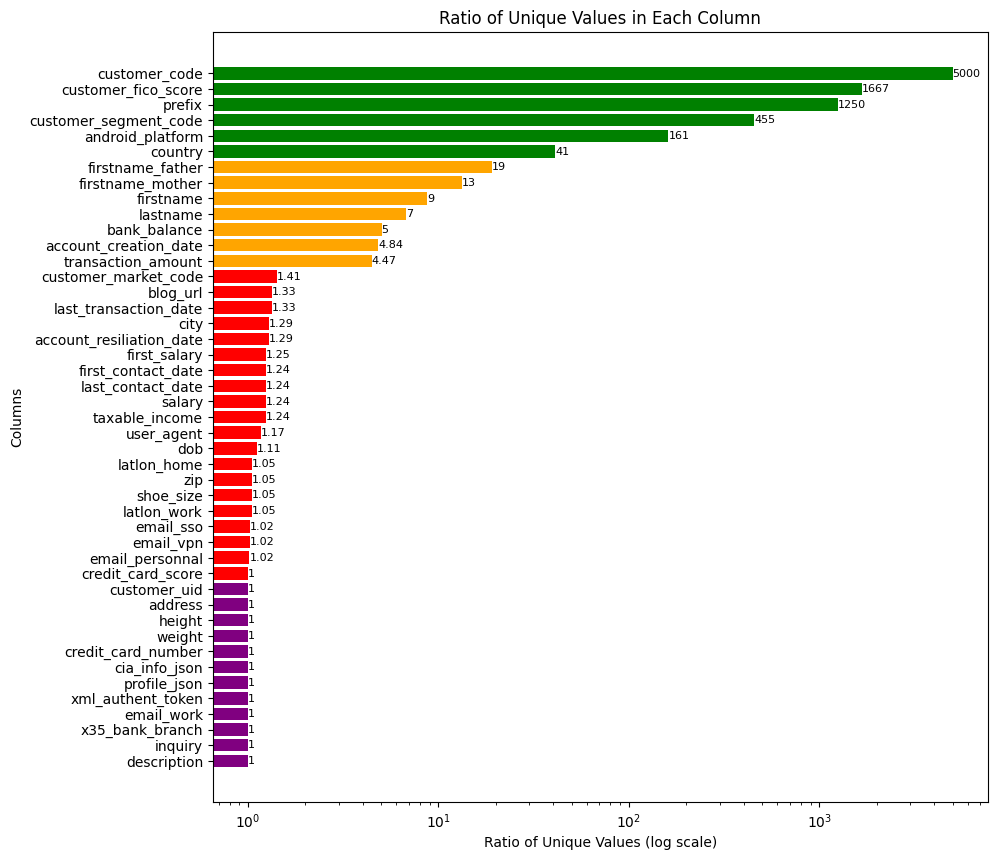

In [7]:
unique_count = []
for column in df.columns:
    ratio_unique_value = len(df[column]) / len(df[column].unique())
    unique_count.append((column, ratio_unique_value))

unique_count.sort(key=lambda x: x[1])

thresholds = [1, 2, 20]  
colors = ['purple', 'red', 'orange', 'green']

color_map = np.digitize([ratio for _, ratio in unique_count], thresholds, right=True)

columns, ratios = zip(*unique_count)
plt.figure(figsize=(10, 10))
bar_plot = plt.barh(columns, ratios, color=[colors[idx] for idx in color_map])
plt.xscale('log')
plt.xlabel('Ratio of Unique Values (log scale)')
plt.ylabel('Columns')
plt.title('Ratio of Unique Values in Each Column')

for i, ratio in enumerate(ratios):
    if ratio > 5 or int(ratio * 100) % 10 == 0:
        text = f'{ratio:.0f}'
    else:
        text = f'{ratio:.2f}'
    plt.text(ratio, i, text, ha='left', va='center', color='black', fontsize=8)

plt.show()

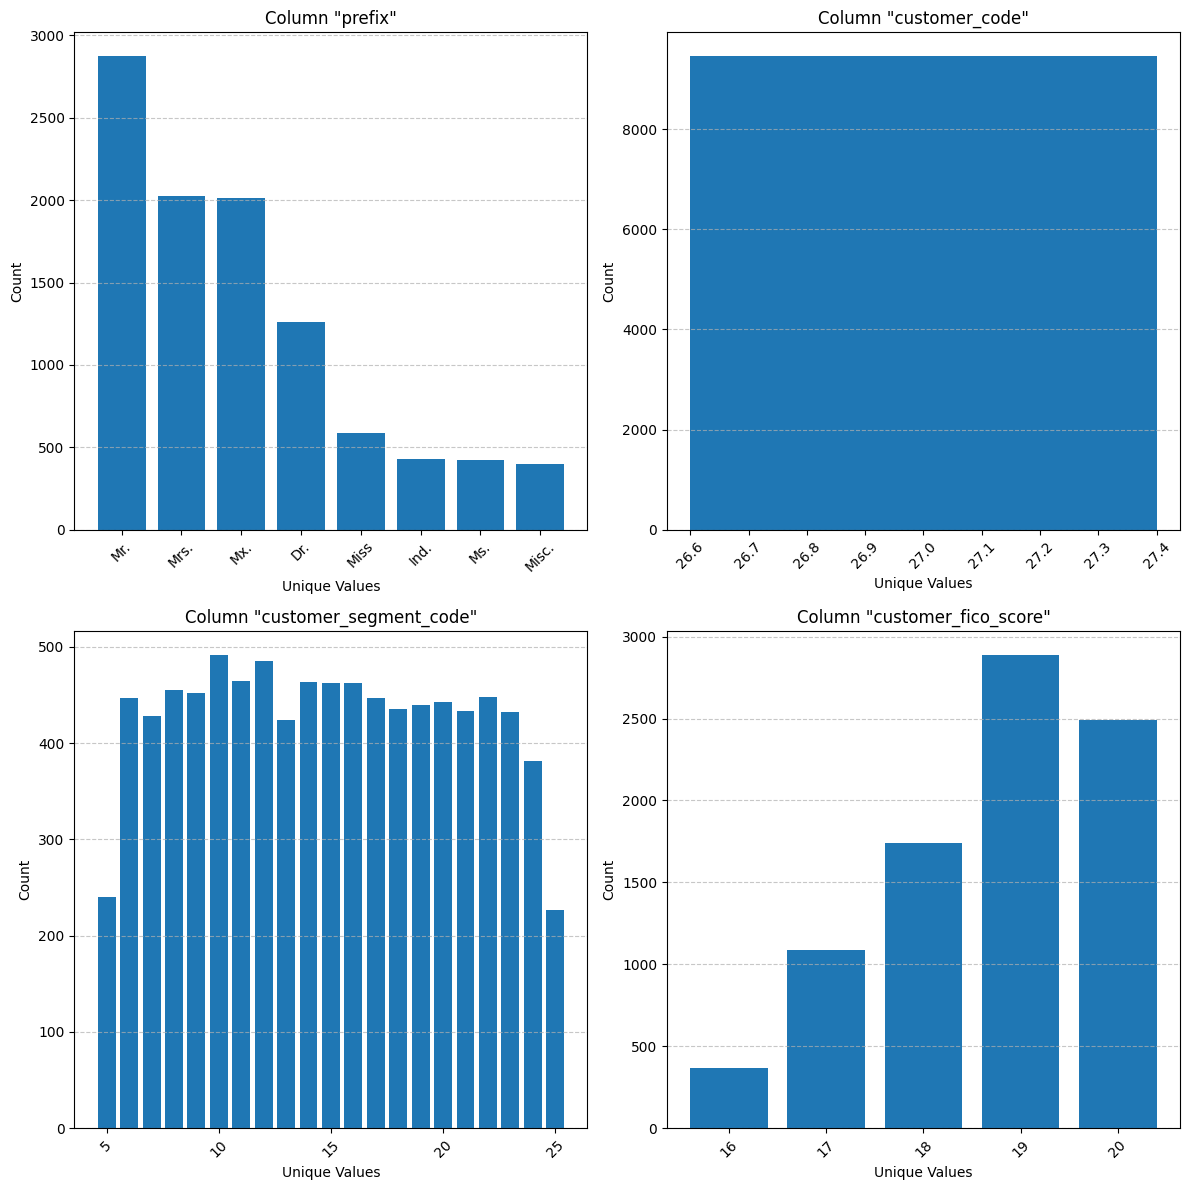

In [8]:
max_unique_val = 30

valid_columns_count = sum(1 for column_name in df.columns if len(df[column_name].value_counts().index) < 20)

num_rows = (valid_columns_count + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

if num_rows == 1 and num_cols == 1:
    axs = [axs]

subplot_index = 0
for column_name in df.columns:
    unique_values_distribution = df[column_name].value_counts()
    if len(unique_values_distribution.index) < max_unique_val:
        row_index = subplot_index // num_cols
        col_index = subplot_index % num_cols

        axs[row_index, col_index].bar(unique_values_distribution.index, unique_values_distribution.values)
        axs[row_index, col_index].set_title('Column "{}"'.format(column_name))
        axs[row_index, col_index].set_xlabel('Unique Values')
        axs[row_index, col_index].set_ylabel('Count')
        axs[row_index, col_index].tick_params(axis='x', rotation=45)
        axs[row_index, col_index].grid(axis='y', linestyle='--', alpha=0.7)
        
        subplot_index += 1

plt.tight_layout()
plt.show()

# String Cleaning 11 / 23

## Normal 11 / 18

### Unique value 7 / 7

This method is allowing us to systematically clean all 4 name columns and serves as a showcase of what our work could have looked like if we were able to have more time.

In [74]:
class NameCleaning:
    def __init__(self, df, interested_column, pattern=re.compile(r'[^a-zA-Z]'), additional_names=None):
        if additional_names is None:
            additional_names = []
        self.df = df.copy()
        self.interested_column = interested_column
        self.still_valid_names = [(index, row) for index, row in self.df.iterrows()]
        self.pattern = pattern
        self.inconsistencies = []
        self.inconsistency_count = 0
        self.additional_names = additional_names
        self.correct_names = [] + self.additional_names #set(nltk.corpus.names.words()).union(additional_names)
        self.inferred_names = []
        self.names_without_match = []
        self.still_valid_indexes = []
        self.raw_dirtiness_percentages = []
        self.not_name_percentages = []
        
    def raw_dirtiness(self):
        total_records = len(self.df[self.interested_column])
        dirty_records = len(self.inconsistencies) + len(self.names_without_match)
        self.raw_dirtiness_percentages.append((dirty_records / total_records) * 100)
        del total_records, dirty_records
    
    """    
    def not_name_dirtiness(self, output_dataframe = None):
            total_records = len(output_dataframe[self.interested_column])
            unknown_count = self.df[self.interested_column].str.lower().eq('unknown').sum()
            undefined_count = self.df[self.interested_column].str.lower().eq('undefined').sum()
            self.not_name_percentages.append(((unknown_count + undefined_count) / total_records) * 100)
            del total_records, unknown_count, undefined_count
    """
    
    def print_dirtiness(self, dirtiness_type, before, after):
        print(f"\n{dirtiness_type} dirtiness before: {before}%\n"
              f"{dirtiness_type} dirtiness after: {after}%")
        
    def find_missing_values(self, show = False):
        self.still_valid_indexes = []
        for still_valid_index, still_valid_name in enumerate(self.still_valid_names):
            row = still_valid_name[1]
            index = still_valid_name[0]
            name = row[self.interested_column]
            if pd.isna(name):
                self.names_without_match.append((index, name))
                self.still_valid_indexes.append(still_valid_index)
        self.still_valid_indexes.sort(reverse=True)
        for index in self.still_valid_indexes:
            del self.still_valid_names[index]
        if show:
            print('Done !')
            self.print_names_without_match()
            
    def print_names_without_match(self):
            if not self.names_without_match :
                print('No missing values detected yet')
            else:
                print(f'There are {len(self.names_without_match)} missing value(s) so far in the column {self.interested_column}')
                print('The missing value(s)')
                for i in self.names_without_match:
                    print(f"row {i[0]}: {i[1]}")
        
    def identify_inconsistencies(self, show = False, method = None):
        if method is None:
            method = self.is_incorrect
        if method == self.is_unknown and len(self.correct_names) == len(self.additional_names):
            self.correct_names = list(nltk.corpus.names.words()) + self.additional_names
        self.still_valid_indexes = []
        for still_valid_index, still_valid_name in enumerate(self.still_valid_names):
            row = still_valid_name[1]
            index = still_valid_name[0]
            name = row[self.interested_column]
            if isinstance(name, str):
                if method(name):
                    self.append_inconsistencies(index, name, still_valid_index)
            else:
                self.append_inconsistencies(index, name, still_valid_index)
        if method == self.is_incorrect:
            self.correct_names += self.df[~self.df.index.isin([i[0] for i in self.inconsistencies])][self.interested_column].tolist()           
        self.print_inconsistencies(show)
        self.still_valid_indexes.sort(reverse=True)
        for index in self.still_valid_indexes:
            del self.still_valid_names[index]
    
    def append_inconsistencies(self, index, name, still_valid_index):
        if index not in [item[0] for item in self.inconsistencies]:
            self.inconsistencies.append((index, name))
            self.inconsistency_count += 1
            self.still_valid_indexes.append(still_valid_index)
            
    def is_unknown(self, name):
        if name not in self.correct_names:
            return True
        else:
            return False
        
    def is_incorrect(self, name):
        if re.search(self.pattern, name):
            return True
        else:
            return False

    def print_inconsistencies(self, show):
        if show:
            print("Summary of inconsistencies:")
            for count, inconsistency in self.inconsistencies:
                print(f"Row {count}: {inconsistency}")
            print(f"Number of inconsistent {self.interested_column}: {self.inconsistency_count}")
  
    def infer_correct_names(self, show = True, score_threshold = 0, min_length = 0):
        global closest_match
        self.still_valid_indexes = []
        for inconsistency_index, inconsistency in enumerate(self.inconsistencies):
            index = inconsistency[0]
            name = inconsistency[1]
            length = len(re.sub(self.pattern, '', name)) + 1
            score = 0
            if length >= min_length:
                filtered_names = [name for name in self.correct_names if len(name) == length ]
                closest_match, score = process.extractOne(name, filtered_names)
            if score >= score_threshold:
                if not re.search(self.pattern, closest_match):         
                    self.inferred_names.append((index, name, closest_match, re.search(self.pattern, closest_match), score))
            else:   
                self.names_without_match.append((index, name))
            self.still_valid_indexes.append(inconsistency_index)
        self.print_inferred(show)
        self.still_valid_indexes.sort(reverse=True)
        for index in self.still_valid_indexes:
            del self.inconsistencies[index]
        
    def print_inferred(self, show):
        if show:
            for index, incorrect, inferred, invalid, score in self.inferred_names:
                print(f"Row {index}: {incorrect} -> {inferred} (Similarity Score: {score})")  
            print(f"\n{len(self.inferred_names)} names from {self.interested_column} have been inferred")
            if self.names_without_match:
                print(f"There are {len(self.names_without_match)} names without a match\n")
                # for i in self.names_without_match:
                #    print(f"row:{i[0]} -> {i[1]}")
            else:
                print('\nThere is no need for further processing, every invalid names identified have been processed !')
                    
    def replace_names_without_match(self, invalid_replacement="invalid", unknown_replacement = "unknown", show = False):
        for index, name in self.names_without_match:
            if isinstance(name, str):
                replacement = invalid_replacement
            else:
                replacement = unknown_replacement
            self.inferred_names.append((index,'',replacement,'',''))
            if show:
                print(f'Row {index}: {name} -> {replacement}')
    
    def generate_wordcloud(self, names = None, description = 'Inconsistent Names'):
        # Concatenate all inconsistent names into a single string
        if names == self.inconsistencies or names is None:
            names_str = ' '.join([re.sub(self.pattern, '', name) for _, name in self.inconsistencies])
            count = len(self.inconsistencies) + len(self.names_without_match)
        elif names == self.inferred_names:
            names_str = ' '.join([name for _, _, name, _, _ in self.inferred_names])
            count = len(self.inferred_names)
        else:
            print('Invalid or unsupported names')
            return None
        
        # Calculate the frequency of each word
        word_counts = Counter(names_str.split())
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', regexp=r'\w+').generate_from_frequencies(word_counts)
        # Plot word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud of the {count} {description} (No special characters, they are not well supported by WordCloud)')
        plt.axis('off')
        plt.show()
    
    def save(self, output_df, filename, show = False):
        output_df.to_csv(filename, index=False)
        if show:
            for index, _, inferred, _, _ in self.inferred_names:
                output_df.at[index, self.interested_column] = inferred
            df_comparison = pd.concat([self.df[self.interested_column], output_df[self.interested_column]], axis=1)
            df_comparison.columns = ['Before Processing', 'After Processing']
            
            print(f"\nCleaned DataFrame saved successfully.\n"
                  f"{df_comparison}")

#### $lastname$ ✅  

In this column we should find the last name of the user / customer.  

- Problem: There are some typing errors (Ba+rett, Evùns…)  
- Cause: They seem to be caused by human errors as there is no pattern in the error place nor weird entries (Œ$ for exemple)
- Solution: 1. We identify all data point containing any other value than the alphabet (including upper case) or any missing value, 2. We compare the inconsistencies with same length name and compute their levenshtein distance and keep the best one (given some conditions to satisfy). 3. Save the result in **output_df** and **output.csv** file

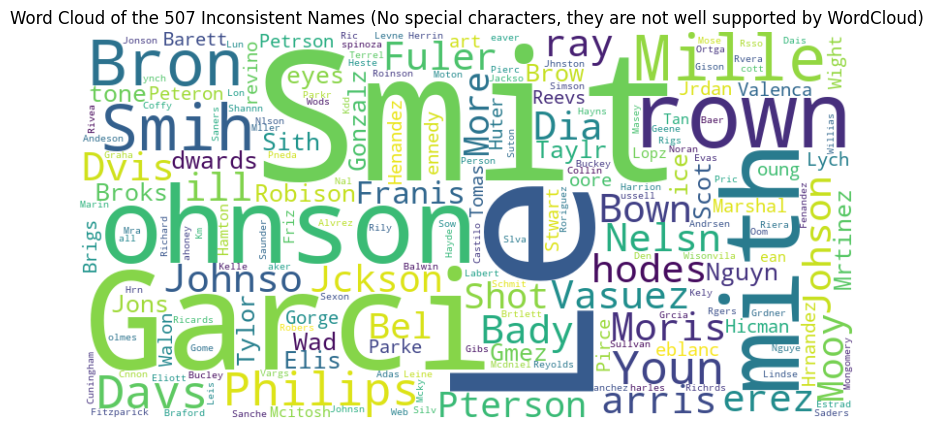

In [75]:
interested_column = 'lastname'
lastname_clean_obj = NameCleaning(df, interested_column)
lastname_clean_obj.find_missing_values(show = False)
lastname_clean_obj.identify_inconsistencies(show = False)
lastname_clean_obj.raw_dirtiness()
lastname_clean_obj.generate_wordcloud()

In [76]:
lastname_clean_obj.infer_correct_names(show = True)
lastname_clean_obj.save(output_df, output_csv_path, show = True)

Row 5: Peter`on -> Peterson (Similarity Score: 88)
Row 62: Pet}rson -> Peterson (Similarity Score: 88)
Row 75: Ly~ch -> Lynch (Similarity Score: 80)
Row 146: G,orge -> George (Similarity Score: 83)
Row 151: Garci^ -> Garcia (Similarity Score: 91)
Row 157: Marshal! -> Marshall (Similarity Score: 93)
Row 171: *oore -> Moore (Similarity Score: 89)
Row 202: ~ohnson -> Johnson (Similarity Score: 92)
Row 203: Vas<uez -> Vasquez (Similarity Score: 86)
Row 230: St#wart -> Stewart (Similarity Score: 86)
Row 286: Ba%rett -> Barrett (Similarity Score: 86)
Row 313: ?hodes -> Rhodes (Similarity Score: 91)
Row 323: B%own -> Brown (Similarity Score: 80)
Row 360: 'eblanc -> Leblanc (Similarity Score: 92)
Row 426: Valenc`a -> Valencia (Similarity Score: 88)
Row 428: Reev\\s -> Reeves (Similarity Score: 79)
Row 438: H~rnandez -> Hernandez (Similarity Score: 89)
Row 439: )art -> Hart (Similarity Score: 86)
Row 440: J_rdan -> Jordan (Similarity Score: 83)
Row 451: Parke_ -> Parker (Similarity Score: 83)
R

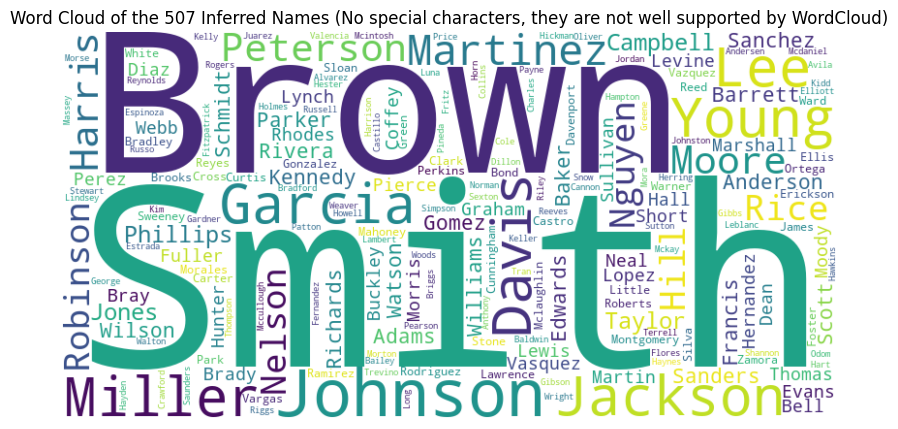

In [77]:
lastname_clean_obj.generate_wordcloud(names = lastname_clean_obj.inferred_names, description = 'Inferred Names')
lastname_clean_obj.raw_dirtiness()

In [78]:
lastname_clean_obj.print_dirtiness("Raw",lastname_clean_obj.raw_dirtiness_percentages[0], lastname_clean_obj.raw_dirtiness_percentages[1])
del lastname_clean_obj
# not_name_percentages


Raw dirtiness before: 5.07%
Raw dirtiness after: 0.0%


#### $firstname$  ✅
 This column should contain the user / customer / subject last name
- problem: There are some typing errors with spaces (L   sa, Ell   n…)

- cause: Probably also some humain error (also it is weird for human to randomly type a space in name)

- solution: Same as 'lastname' column

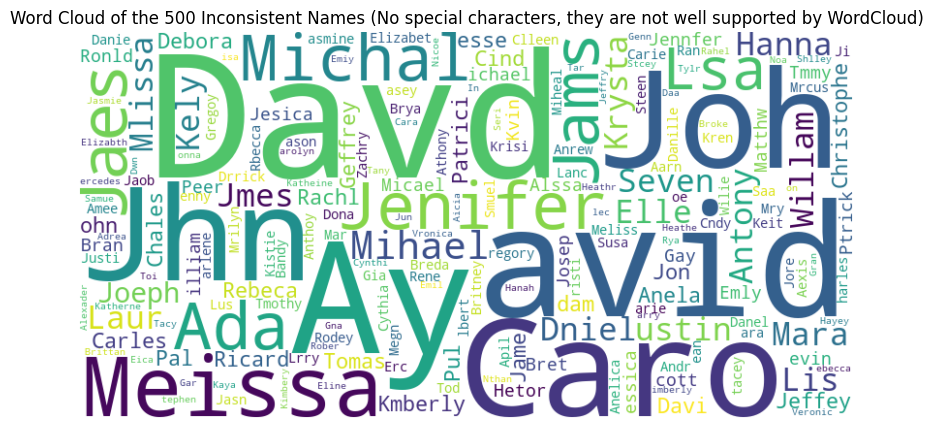

In [80]:
interested_column = 'firstname'
firstname_clean_obj = NameCleaning(df, interested_column)
firstname_clean_obj.find_missing_values(show = False)
firstname_clean_obj.identify_inconsistencies(show = False)
firstname_clean_obj.raw_dirtiness()
firstname_clean_obj.generate_wordcloud()

In [81]:
firstname_clean_obj.infer_correct_names(show = True)
firstname_clean_obj.save(output_df, output_csv_path, show = True)

Row 11: Elizabet    -> Elizabeth (Similarity Score: 94)
Row 16:    ara -> Sara (Similarity Score: 86)
Row 26:    ean -> Jean (Similarity Score: 86)
Row 27: Jor   e -> Jorge (Similarity Score: 67)
Row 29:   asey -> Casey (Similarity Score: 89)
Row 33: Laur     -> Laura (Similarity Score: 89)
Row 39: A  y -> Amy (Similarity Score: 64)
Row 84: R    becca -> Rebecca (Similarity Score: 71)
Row 93: Krysta   -> Krystal (Similarity Score: 92)
Row 105: Er          c -> Eric (Similarity Score: 45)
Row 106: K    ren -> Karen (Similarity Score: 68)
Row 166: Ren      e -> Derek (Similarity Score: 57)
Row 184: Danie    -> Daniel (Similarity Score: 91)
Row 196: Don        a -> Jason (Similarity Score: 57)
Row 225: Cy       thia -> Cynthia (Similarity Score: 74)
Row 262: C          lleen -> Colleen (Similarity Score: 74)
Row 265: Lanc        -> Lance (Similarity Score: 89)
Row 271: T       mothy -> Timothy (Similarity Score: 71)
Row 277: Ant          ony -> Anthony (Similarity Score: 74)
Row 295: Zach

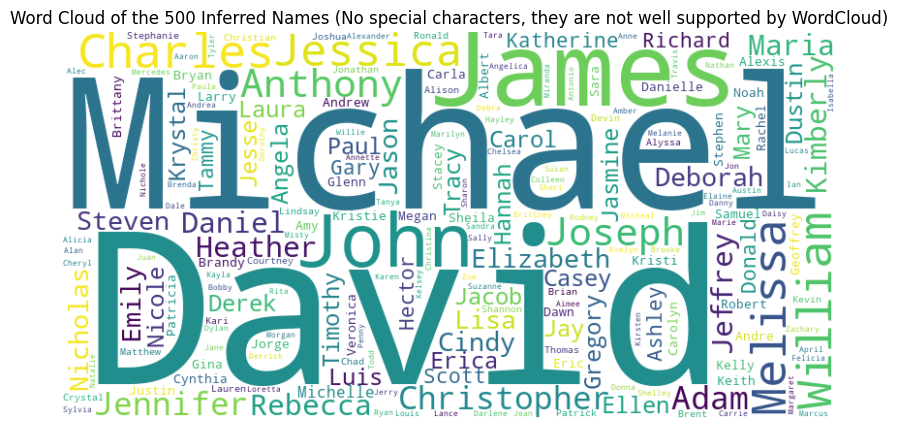

In [82]:
firstname_clean_obj.generate_wordcloud(names = firstname_clean_obj.inferred_names, description = 'Inferred Names')
firstname_clean_obj.raw_dirtiness()

In [83]:
firstname_clean_obj.print_dirtiness("Raw",firstname_clean_obj.raw_dirtiness_percentages[0], firstname_clean_obj.raw_dirtiness_percentages[1])
del firstname_clean_obj


Raw dirtiness before: 5.0%
Raw dirtiness after: 0.0%


#### $firstname mother$ ✅  

This column should contain the user / customer / subject mother first name
- problem: There are some character errors (Juâ€‹ie, Laâ€‹ra…)
- cause: Probably also some human error (also it is weird for human to randomly type a space in name)
- solution: Same as 'lastname' column

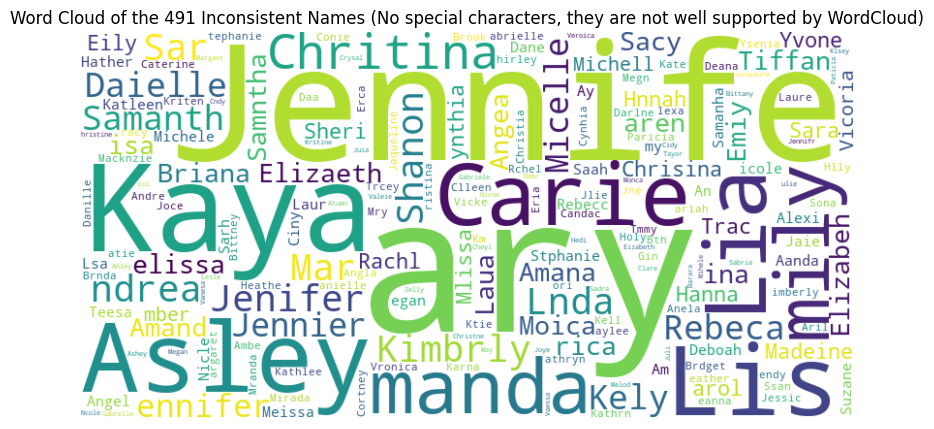

In [84]:
interested_column = 'firstname_mother'
firstname_mother_clean_obj = NameCleaning(df, interested_column)
firstname_mother_clean_obj.find_missing_values(show = False)
firstname_mother_clean_obj.identify_inconsistencies(show = False)
firstname_mother_clean_obj.raw_dirtiness()
firstname_mother_clean_obj.generate_wordcloud()

In [85]:
firstname_mother_clean_obj.infer_correct_names(show = True)
firstname_mother_clean_obj.save(output_df, output_csv_path, show = True)

Row 37: ​endy -> Wendy (Similarity Score: 89)
Row 64: ​ariah -> Mariah (Similarity Score: 91)
Row 99: Meg​n -> Megan (Similarity Score: 80)
Row 172: As​ley -> Ashley (Similarity Score: 83)
Row 234: ​lexa -> Alexa (Similarity Score: 89)
Row 237: Vick​e -> Vickie (Similarity Score: 83)
Row 294: Jo​ce -> Joyce (Similarity Score: 80)
Row 317: Eri​a -> Erika (Similarity Score: 80)
Row 321: T​mmy -> Tammy (Similarity Score: 80)
Row 324: ​eanna -> Deanna (Similarity Score: 91)
Row 329: ​isa -> Lisa (Similarity Score: 86)
Row 348: Cyn​hia -> Cynthia (Similarity Score: 86)
Row 392: Mira​da -> Miranda (Similarity Score: 86)
Row 407: ​hirley -> Shirley (Similarity Score: 92)
Row 495: ​manda -> Amanda (Similarity Score: 91)
Row 510: C​lleen -> Colleen (Similarity Score: 86)
Row 526: Kell​ -> Kelly (Similarity Score: 89)
Row 610: Eliza​eth -> Elizabeth (Similarity Score: 89)
Row 627: ​tephanie -> Stephanie (Similarity Score: 94)
Row 629: Jessic​ -> Jessica (Similarity Score: 92)
Row 681: Br​dget ->

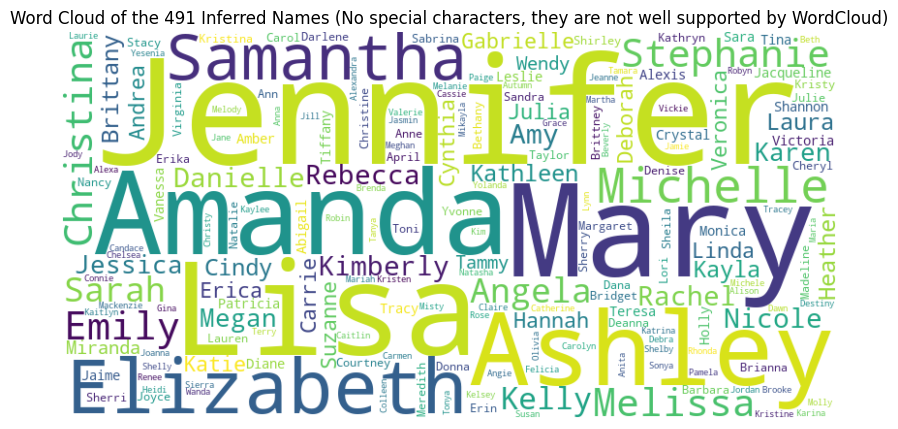

In [86]:
firstname_mother_clean_obj.generate_wordcloud(names = firstname_mother_clean_obj.inferred_names, description = 'Inferred Names')
firstname_mother_clean_obj.raw_dirtiness()

In [87]:
firstname_mother_clean_obj.print_dirtiness("Raw",firstname_mother_clean_obj.raw_dirtiness_percentages[0], firstname_mother_clean_obj.raw_dirtiness_percentages[1])
del firstname_mother_clean_obj


Raw dirtiness before: 4.91%
Raw dirtiness after: 0.0%


#### firstname_father ✅
This column should contain the user / customer / subject father first name
- problem: There are some incomplete names (Jcob, onald…) + 92 missing values.
- cause: Probably also some human error
- solution: Same as 'lastname' column and this time to identify the inconsistencies we used the nltk library of names

(for this problem some names are missing too many characters, thus we are not able to confidently infer their true name. In this case we chose to replace the original value with **invalid**, meaning that there was a name but too dirty to be inferred. Additionally, this is the only column of name with missing values. We were not able to find any cross information to infer the missing values. We labeled the NaN as **unknow**.)

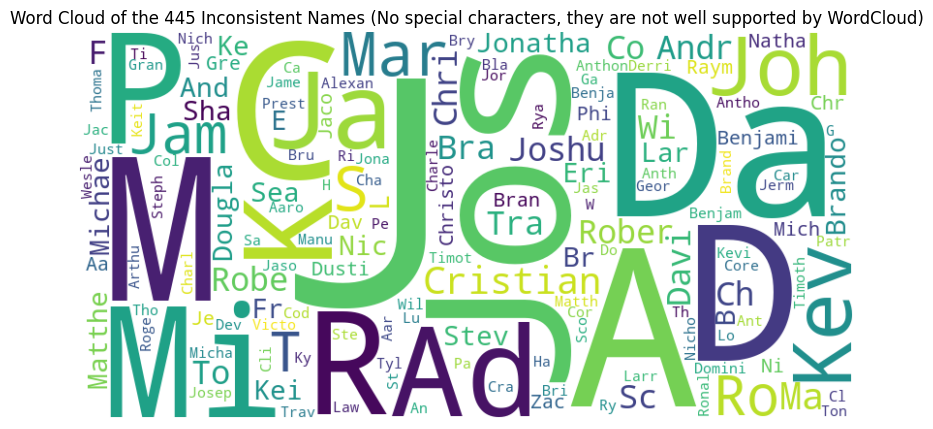

In [88]:
interested_column = 'firstname_father'
firstname_father_clean_obj = NameCleaning(df, interested_column, additional_names = ['Colton',
                                                                                     'Dakota',
                                                                                     'Justin', 
                                                                                     'David', 
                                                                                     'Benjamin', 
                                                                                     'Malik', 
                                                                                     'Alexander',
                                                                                     'Keith'])
firstname_father_clean_obj.find_missing_values(show = False)
firstname_father_clean_obj.identify_inconsistencies(method = firstname_father_clean_obj.is_unknown, show = False)
firstname_father_clean_obj.raw_dirtiness()
firstname_father_clean_obj.generate_wordcloud()

In [89]:
firstname_father_clean_obj.infer_correct_names(score_threshold = 90, min_length = 4, show = True)
firstname_father_clean_obj.replace_names_without_match(show = True)
firstname_father_clean_obj.save(output_df, output_csv_path, show = True)

Row 60: Anthon -> Anthony (Similarity Score: 92)
Row 206: Jonatha -> Jonathan (Similarity Score: 93)
Row 303: Rober -> Robert (Similarity Score: 91)
Row 394: Cristian -> Christian (Similarity Score: 94)
Row 472: Cristian -> Christian (Similarity Score: 94)
Row 483: Domini -> Dominic (Similarity Score: 92)
Row 640: Brando -> Brandon (Similarity Score: 92)
Row 1273: Michae -> Michael (Similarity Score: 92)
Row 1430: Dougla -> Douglas (Similarity Score: 92)
Row 1673: Jonatha -> Jonathan (Similarity Score: 93)
Row 1851: Matthe -> Matthew (Similarity Score: 92)
Row 2315: Joshu -> Joshua (Similarity Score: 91)
Row 2353: Joshu -> Joshua (Similarity Score: 91)
Row 2461: Victo -> Victor (Similarity Score: 91)
Row 2783: Benjami -> Benjamin (Similarity Score: 93)
Row 2931: Micha -> Michal (Similarity Score: 91)
Row 3060: Josep -> Joseph (Similarity Score: 91)
Row 3177: Michae -> Michael (Similarity Score: 92)
Row 3593: Cristian -> Christian (Similarity Score: 94)
Row 5284: Matthe -> Matthew (Simi

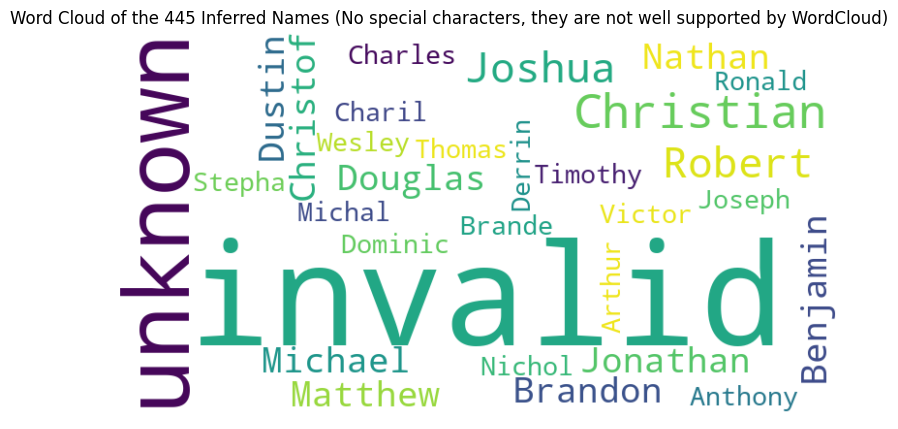

In [90]:
firstname_father_clean_obj.generate_wordcloud(names = firstname_father_clean_obj.inferred_names, description = 'Inferred Names')
firstname_father_clean_obj.raw_dirtiness()

In [91]:
firstname_father_clean_obj.print_dirtiness("Raw",firstname_father_clean_obj.raw_dirtiness_percentages[0], firstname_father_clean_obj.raw_dirtiness_percentages[1])

# firstname_father_clean_obj.print_dirtiness("Not Name",firstname_father_clean_obj.not_name_percentages[0], firstname_father_clean_obj.not_name_percentages[1])

del firstname_father_clean_obj


Raw dirtiness before: 4.45%
Raw dirtiness after: 4.01%


#### description ✅
We assumed that the return to the line was the problem

In [35]:
def clean_and_save_df(df, interested_column, output_csv_path):
    # Remove line breaks, semicolons, and trailing double quotes from the query column
    
    df[interested_column] = df[interested_column].str.replace(r'[\n;"|]', ' ', regex=True) # Remove unwanted characters
    df[interested_column] = df[interested_column].apply(lambda x: re.compile(r'.*?([a-zA-Z].*)').findall(x)[0]) # Replace multiple whitespace with a single space
    # Save the cleaned DataFrame to a file
    df.to_csv(output_csv_path, index=False)
    
    print(f"Data cleaning on {interested_column} completed. Cleaned DataFrame saved as '{output_csv_path}'.\n")

def compare_df_line(interested_column, df, output_df, loc):
    print(f'Value before cleaning:\n'
          f'{df[interested_column].iloc[loc]}\n'
          f'--------\n'
          f'Value after cleaning:\n{output_df[interested_column].iloc[loc]}')

In [36]:
interested_column = 'description'
clean_and_save_df(output_df, interested_column, output_csv_path)
compare_df_line(interested_column, df, output_df, 1)

Data cleaning on description completed. Cleaned DataFrame saved as 'output.csv'.

Value before cleaning:
Out language trade bank science. Accept hour this source piece.
Beat will computer leg safe. Myself west read close several quite street.
--------
Value after cleaning:
Out language trade bank science. Accept hour this source piece. Beat will computer leg safe. Myself west read close several quite street.


#### inquiry ✅
Too many \n and quotes "

In [96]:
interested_column = 'inquiry'
clean_and_save_df(output_df, interested_column, output_csv_path)
compare_df_line(interested_column, df, output_df, 1)

Data cleaning on inquiry completed. Cleaned DataFrame saved as 'output.csv'.

Value before cleaning:
Try how deal. Save area serious wind.
Chair person contain walk letter also theory. Mr respond later most tough. Health but view.
--------
Value after cleaning:
Try how deal. Save area serious wind. Chair person contain walk letter also theory. Mr respond later most tough. Health but view.


#### address ✅
There are \n in between the street and the city name like: 50882 Molina Lock **\n** South Marcchester, FM 91039

In [102]:
interested_column = 'address'

rows_with_newline = output_df[output_df[interested_column].str.contains('\n')]

# Count the number of rows with '\n'
num_rows_with_newline = len(rows_with_newline)
print(f"Number of rows with '\\n': {num_rows_with_newline}")


print(f"Rows with '\\n': {rows_with_newline[interested_column]}")

# Remove '\n' from the address column
output_df['address'] = output_df['address'].str.replace('\n', ', ')

# Output the cleaned DataFrame
print("\nOriginal DataFrame:")
print(df[interested_column])
print("\nCleaned DataFrame:")
print(output_df[interested_column])

output_df.to_csv(output_csv_path, index=False)

Number of rows with '\n': 10000
Rows with '\n': 0                         3249 Sims Run\nNorth Jennifer, UT 17088
1                    288 Carroll Radial\nWest Emilyland, GU 99196
2                   11875 Lacey Bridge\nPort Austinside, IN 99111
3       01116 Johnson Island Apt. 879\nNew Desireeshire, GA 61675
4                   41665 Gutierrez Skyway\nKylechester, ID 83582
                                  ...                            
9995                    993 Peter Groves\nWilsonchester, GA 40256
9996        6678 Thompson Heights Apt. 692\nSouth Laura, AR 06854
9997             113 Lee Forest Suite 347\nRodriguezton, NC 11612
9998               50882 Molina Lock\nSouth Marcchester, FM 91039
9999     9015 Douglas River Suite 429\nRodriguezchester, HI 58022
Name: address, Length: 10000, dtype: object

Original DataFrame:
0                         3249 Sims Run\nNorth Jennifer, UT 17088
1                    288 Carroll Radial\nWest Emilyland, GU 99196
2                   11875 Lac

### Categorical 4 / 7

#### prefix ✅
the prefix are not always well suited to the user.

In [209]:
class SexClassifier:
    def __init__(self):
        self.model = None
        self.threshold = 0.45

    def train(self, example_names):
        """
        Train the sex classification model.
        
        Args:
            example_names (list): List of example names for training.
        """
        self.model = nqg.NBGC()
        self.model.tune(example_names, update=False, candidates=[0.45, 0.35, 0.25, 0.15, 0.05])

    def classify(self, firstnames):
        """
        Classify the sexes for a list of first names.

        Args:
            firstnames (list): List of first names to classify.

        Returns:
            list: List of predicted sexes for each first name.
        """
        return self.model.classify(firstnames)

def infer_sex(df):
    """
    Infer sex based on first names and add it as a new column 'sex' in the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'firstname' column.
    
    Returns:
        pd.DataFrame: DataFrame with the inferred sex added as a new column.
    """
    classifier = SexClassifier()
    classifier.train(nqg.example_names)
    sexes = classifier.classify(df['firstname'].tolist())
    
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    
    # Add inferred sex as a new column
    df_copy['sexes'] = sexes
    
    return df_copy

def plot_distribution(unique_values, title, xlabel, ylabel, rotation=0, color=None):
    """
    Plot distribution of unique values.
    
    Args:
        unique_values (pd.Series): Series containing unique values and their counts.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        rotation (int, optional): Rotation angle for x-axis labels. Defaults to 0.
        color (str, optional): Color for the bars. Defaults to None.
    """
    plt.figure(figsize=(10, 6))
    unique_values.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def infer_sex_based_on_prefix(df):
    """
    Infer sex based on the prefix column.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'prefix' column.
    
    Returns:
        pd.Series: Series containing inferred sexes.
    """
    inferred_sexes = []
    for prefix in df['prefix']:
        if prefix == 'Mr.':
            inferred_sexes.append('gm')
        elif prefix in ['Mrs.', 'Miss', 'Ms.']:
            inferred_sexes.append('gf')
        elif prefix in ['Mx.', 'Dr.', 'Misc.', 'Ind.']:
            inferred_sexes.append('-')
    return pd.Series(inferred_sexes)

def count_errors(true_sexes, inferred_sexes):
    """
    Count the number of errors made by using inferred sexes as sex indicators.
    
    Args:
        true_sexes (pd.Series): Series containing true sexes based on prefix.
        inferred_sexes (pd.Series): Series containing inferred sexes based on prefix.
    
    Returns:
        int: Number of errors.
    """
    errors = sum(true_sexes != inferred_sexes)
    return errors

def plot_inferred_sex_distribution(inferred_sexes):
    """
    Plot distribution of inferred sexes.
    
    Args:
        inferred_sexes (pd.Series): Series containing inferred sexes.
    """
    unique_values_distribution = inferred_sexes.value_counts()
    plt.figure(figsize=(8, 5))
    unique_values_distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Inferred sexes based on Prefix')
    plt.xlabel('Inferred sexes')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_error_rate(true_sexes, inferred_sexes):
    """
    Plot the error rate visually.
    
    Args:
        true_sexes (pd.Series): Series containing true sexes.
        inferred_sexes (pd.Series): Series containing inferred sexes.
    """
    # Count errors
    errors = count_errors(true_sexes, inferred_sexes)
    
    # Calculate error rate
    total_samples = len(true_sexes)
    error_rate = (errors / total_samples) * 100
    
    # Plot error rate
    plt.figure(figsize=(3, 5))
    plt.bar(["Error Rate"], [error_rate], color='red')
    plt.title('Error Rate in sex Inference')
    plt.xlabel('Error Rate (%)')
    plt.ylabel('Error Rate')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def save_sex_df(cleaned_df, filename):
    """
    Save the original and cleaned DataFrames to a file.

    Args:
        cleaned_df (pd.DataFrame): Cleaned DataFrame.
        filename (str): Name of the file to save the DataFrames.
    """
    cleaned_df_comparison = pd.concat([df['prefix'], cleaned_df['sexes'], cleaned_df['firstname']], axis=1)
    cleaned_df_comparison.columns = ['Gender', 'Inferred Sex', 'First Name']

    # Save the cleaned DataFrame to a file
    cleaned_df.to_csv(filename, index=False)
    
    print(f"Original and cleaned DataFrames saved successfully.\n"
          f"Difference between Original and Cleaned DataFrames:\n"
          f"{cleaned_df_comparison}")

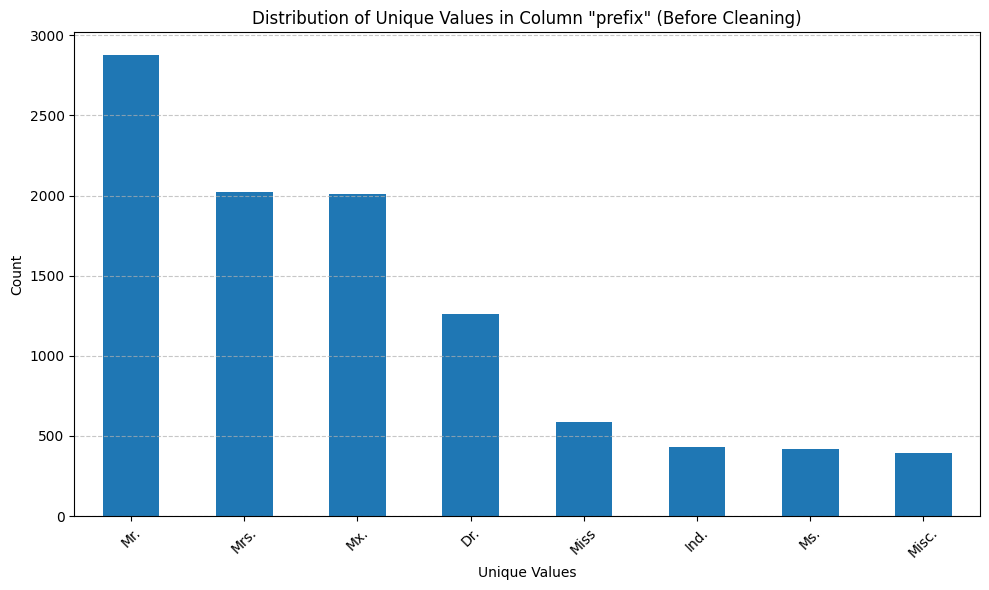

max uncertainty threshold remains 0.1, threshold of 0.15 would classify 87% of sample
---
threshold   .45  .35  .25  .15  .05
percentage  98%  97%  92%  87%  78%


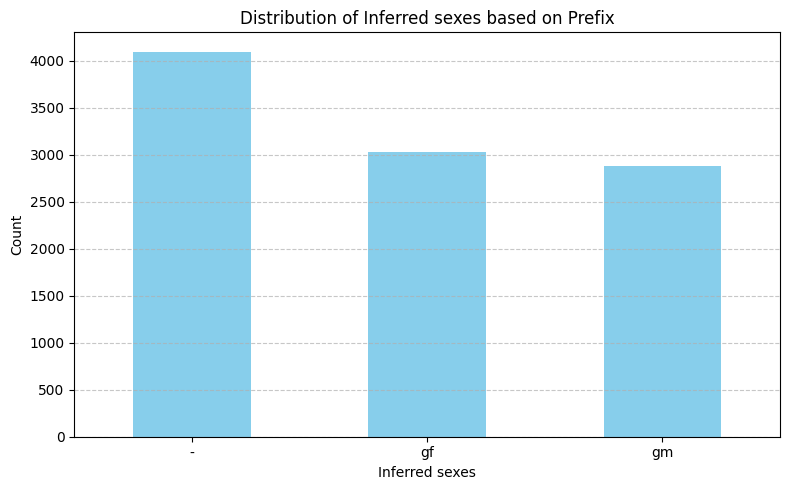

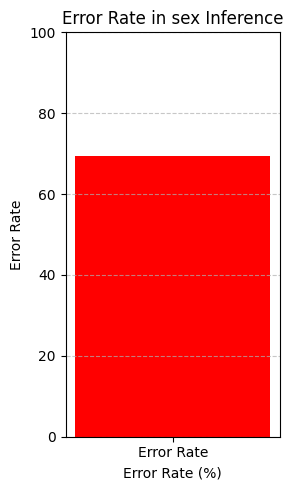

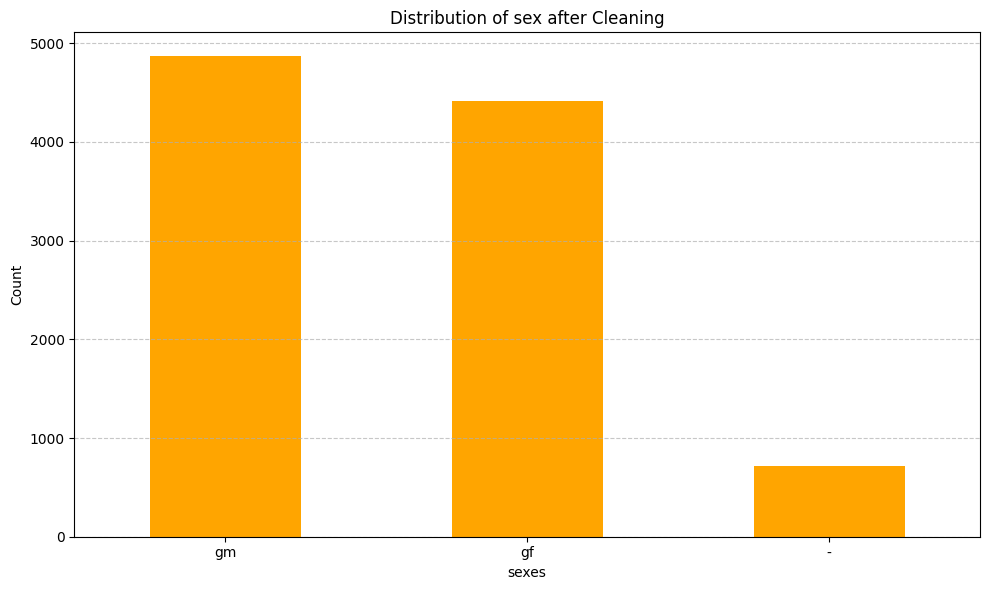

In [210]:
# Visualization before cleaning
interested_column = 'prefix'
unique_values_distribution_before = df[interested_column].value_counts()
plot_distribution(unique_values_distribution_before, f'Distribution of Unique Values in Column "{interested_column}" (Before Cleaning)', 'Unique Values', 'Count', rotation=45)

# Clean the prefix column to infer sex
output_df = infer_sex(output_df)

# Load DataFrame and true sexes based on prefix (replace df_fixed and true_sexes_prefix with your data)
sexes_column = 'sexes'
true_sexes_prefix = output_df[sexes_column]

# Infer sexes based on prefix
prefix_inferred_sexes = infer_sex_based_on_prefix(output_df)

# Plot distribution of inferred sexes
plot_inferred_sex_distribution(prefix_inferred_sexes)

# Plot error rate if we were to assume the sex based on the declared sex
errors = count_errors(true_sexes_prefix, prefix_inferred_sexes)
plot_error_rate(true_sexes_prefix, prefix_inferred_sexes)

# Visualization after cleaning
unique_values_distribution_after = output_df[sexes_column].value_counts()
plot_distribution(unique_values_distribution_after, 'Distribution of sex after Cleaning', sexes_column, 'Count', color='orange')

# Save the output data frame
save_sex_df(output_df, output_csv_path)

#### city ❌
?

#### country ✅
- no problem in country
(some names are to long like “British Indian Ocean Territory (Chagos Archipelago)”, “holy see (vatican city)”, “Slovakia (Slovak Republic)”)

#### android_platform ✅
maybe android is repeated ? (it ranges from 1 to 9 and ?)

#### user_agent ✅
some feld have “PWNED” added randomly

In [172]:
# Find rows containing "PWNED" in the 'user_agent' column
pwned_rows = df[df['user_agent'].str.contains("PWNED")] # .to_list()

# Print the rows
print(pwned_rows['user_agent'])
#print(len(pwned_rows))
del pwned_rows

28                                                                                         Mozilla/PWNED5.0 (compatible; MSIE 6.0; Windows NT 4.0; Trident/5.0)
72      Mozilla/5.0 (iPod; U; CPU iPhone OS 4_0 like Mac OS X; cy-GB) AppleWebKit/533.33.6 (KHTML, like Gecko) Version/4.0.5 Mobile/8PWNEDB119 Safari/6533.33.6
73      Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like Mac OS X; is-IS) AppleWebKit/535.20.6 (KHTML, like Gecko) VersionPWNED/3.0.5 Mobile/8B115 Safari/6535.20.6
112                                                                                   Mozilla/5.0 (Android 3.2.3; Mobile; rv:67.0) Gecko/67.0 Firefox/67PWNED.0
129                                                                                            MozilPWNEDla/5.0 (compatible; MSIE 9.0; Windows CE; Trident/3.0)
                                                                                 ...                                                                           
9901                                    

In [171]:
# Remove "PWNED" from the strings in the 'user_agent' column
output_df['user_agent'] = output_df['user_agent'].str.replace("PWNED", "")

# Save the data frame
output_df.to_csv(output_csv_path, index=False)

# Print the updated DataFrame
print(df['user_agent'].iloc[28])
print(output_df['user_agent'].iloc[28])

Mozilla/PWNED5.0 (compatible; MSIE 6.0; Windows NT 4.0; Trident/5.0)
Mozilla/5.0 (compatible; MSIE 6.0; Windows NT 4.0; Trident/5.0)


#### customer_segment_code ❌
992 missing values

In [5]:
print(output_df['customer_segment_code'])

0       22.0
1       21.0
2       23.0
3       24.0
4       16.0
        ... 
9995     NaN
9996    18.0
9997     7.0
9998    14.0
9999    10.0
Name: customer_segment_code, Length: 10000, dtype: float64


#### customer_market_code ❌  
 1141 missing values and nonsense.

### Email 0 / 4

#### email_personnal ❌
some unexpected characters ex:(hollybailey@example..org).

#### email_sso ❌
unexpected characters ex:(paulthornton@example.Œ≥rg or craigrobe‚Ä¢ts@example.com).

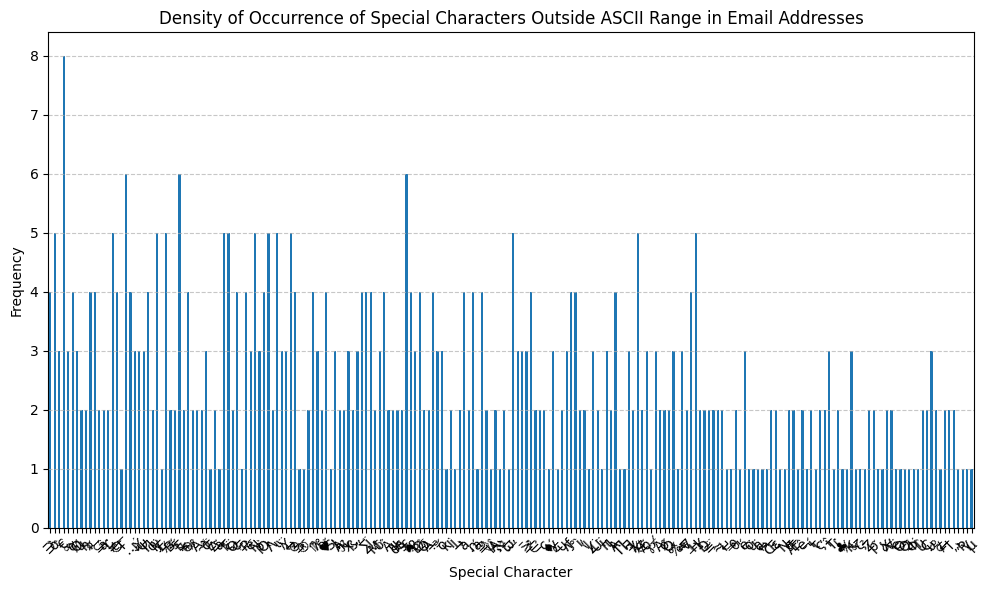

In [140]:
# Function to count occurrence of special characters
def count_special_characters(email):
    special_characters = re.findall(r'[^\x00-\x7F]', email)
    return pd.Series(special_characters).value_counts()

test_df = output_df.copy()
# Count occurrence of special characters
special_characters_count = test_df['email_sso'].apply(count_special_characters).sum()

# Plot the density of occurrence of special characters
plt.figure(figsize=(10, 6))
special_characters_count.plot(kind='bar')
plt.title('Density of Occurrence of Special Characters Outside ASCII Range in Email Addresses')
plt.xlabel('Special Character')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [158]:
import difflib

def find_closest_valid_email(email, valid_emails):
    closest_match = difflib.get_close_matches(email, valid_emails, n=1)
    if closest_match:
        return closest_match[0]
    else:
        return email

# Define a list of valid email addresses for reference
valid_emails = ["johnsmith@example.com", "janesmith@example.com", "bob@example.com"]

def process_emails(df):
    row_indexes = []

    def infer_correct_character(email):
        nonlocal row_index
        row_index += 1
        invalid_special_chars = re.findall(r'[^\x00-\x7F]', email)
        inferred_chars = []
        for char_pair in invalid_special_chars:
            # Get the surrounding characters
            start_index = email.find(char_pair)
            if start_index > 0:
                left_context = email[start_index - 1]
            else:
                left_context = None
            end_index = start_index + len(char_pair)
            if end_index < len(email) - 1:
                right_context = email[end_index]
            else:
                right_context = None
            # Infer the correct character based on the surrounding context
            inferred_char = None
            if left_context and right_context:
                inferred_char = chr((ord(left_context) + ord(right_context)) // 2)
            elif left_context:
                inferred_char = left_context
            elif right_context:
                inferred_char = right_context
            inferred_chars.append((char_pair, inferred_char))
        if invalid_special_chars:
            # print(f'{invalid_special_chars} -> {inferred_chars}')
            row_indexes.append(row_index)
        return inferred_chars

    # Initialize row index
    row_index = -1

    # Infer correct characters for consecutive invalid special characters
    inferred_characters = df['email_sso'].apply(infer_correct_character)

    # Replace consecutive invalid special characters with inferred correct characters
    for index, inferred_chars in inferred_characters.items():
        email = df.at[index, 'email_sso']
        for char_pair, inferred_char in inferred_chars:
            email = email.replace(char_pair, inferred_char)
        df.at[index, 'email_sso'] = email

    # Infer the correct character based on the end of email addresses
    for index, email in df['email_sso'].items():
        if "@" in email:
            # Split email into local part and domain part
            local_part, domain_part = email.split("@")
            if any([char in domain_part for char in ['[^\x00-\x7F]', '�']]):
                # Replace the end of the email with a valid one that is the closest
                closest_email = find_closest_valid_email(domain_part, valid_emails)
                new_email = f"{local_part}@{closest_email}"
                df.at[index, 'email_sso'] = new_email
                # print(f"{output_df['email_sso'].iloc[index]} -> {new_email}")

    return df

# Make a copy of the DataFrame
test_df = output_df.copy()

# Process emails
print(test_df['email_sso'].iloc[9868])
print(process_emails(test_df)['email_sso'].iloc[9868])

# Save the cleaned DataFrame to a file
# processed_df.to_csv(output_csv_path, index=False)

print("Data cleaning completed. Cleaned DataFrame saved as 'output.csv'.")
# del test_df

clarkstephanie@e³ample.net
clarkstephanie@ecample.net
Data cleaning completed. Cleaned DataFrame saved as 'output.csv'.


#### email_vpn ❌  
unexpected characters at the end of the email adresse (​​douglasjohn@yahoo.comhg).

#### email_work ❌  
some unexpected characters ex:(jason72@!dwards-butler.info)

### Hardest - 0 / 5

#### blog_url ❌ url  
?

#### customer_uid ❌hexadecimal  
There doesn't seem to be any inherent issue with this string as a UID. However, depending on the context in which it's used, there are a few considerations:  
Uniqueness: UUIDs are typically used to uniquely identify entities. Ensure that this UUID is generated using a method that guarantees uniqueness within the intended scope (e.g., globally unique for UUIDv4).  
length: UUIDs are usually 128 bits or 32 hexadecimal characters long (excluding hyphens if present). This one seems to be of the correct length.  
Representation: Make sure the UUID is properly represented and stored in whatever system or database it's used in. For example, it might be stored as a string or a binary value depending on the requirements.  

#### xml_authent_token ❌ xml code  
Some unexpected character ? instead of <

#### profile_json ❌ json code  
missing keys

#### cia_info_json ❌ json code  
separators between name and residency, no quotes or unappropriated quotes

# Date 0 / 6

#### dob ❌  
variation in date structure (10/7/2003 or 1987-03-58) > choose one + Customer that have more than 100 yo.

#### account_creation_date ❌  
 variation in date structure (9/21/2000 or 1999-02-29) > choose 1.

#### last_transaction_date ❌  
 hours sometimes added at the end (1/1/1970 0:00) + older than creation date ?

#### account_resiliation_date ❌  
?  
resiliation_date before creation_date ?

#### first_contact_date ❌  
inverted value between first_contact_date and last_contact_date ex: ( 02/10/1998 in first_contact_date and 12/08/1993 in last_contact_date)  

#### last_contact_date ❌  
**09**/**16**/1971 instead of **16**/**09**/1971. 

# Number 0 / 16

## Float 0 / 5

### Coordinate 0 / 3

#### latlon_home ❌  
(Decimal('-29.146587'), Decimal('-69.661657')) instead of -29.146587 latitude and -69.661657 longitude  
default value at (90, 0)  
float:  
lat -90 to 90  
long -180 to 180  

#### latlon_work ❌  
same as latlon_home except for the default coordinate being at (-27.26765, 79.60243)  
float:  
lat -90 to 90  
long -180 to 180  

#### x35_bank_branch ❌  
coordonate out of range ex: ((Decimal('99.108555'), Decimal('-30.3705825'))  
float:  
lat -90 to 90  
long -180 to 180  

## Other 0 / 2

#### credit_card_score ❌  
?

#### shoe_size ❌  
values are too precise like 41,3812748610831 and needs to be rounded to 41,5 in that case. float (with only one precision .5)

## Integer 0 / 11

### Pur Integer 0 / 9

#### salary ❌  
 there is an odd jump from 24999 to 165198,70230679.

#### first_salary ❌  
it ranges from ​​-1525444,1901449 to normal values

#### taxable_income ❌  
from -22811 to normal.

#### transaction_amount ❌  
some values seem to be shifted from 1 digit 2,992

#### credit_card_number ❌  
some cards have missing digits. integer (16 digits)

#### weight ❌  
 some really low values like 0,0118407752664808 which might be due to slippage and will need to be 118,4077 also there is no need to be that precise, 118 is enough. 

#### height ❌  
to high values 401,40395651984.

#### bank_balance ❌  
?  
the balance might be shifted from +500 since the data begins at 500.

#### zip ❌  
for the zip code to be valid it needs to be at least 5 digits and some values are lower than that. integer 5-digits

### Other ? 0 / 2

#### customer_code ❌  
?

#### customer_fico_score ❌  
?